In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import scipy.misc
from scipy.stats import multivariate_normal as mvn
import warnings
warnings.simplefilter(action="ignore")

sn.set()

In [58]:
train = pd.read_csv("MNIST_train.csv")
test = pd.read_csv("MNIST_test.csv")

In [59]:
train.head()

,Unnamed: 0,index,labels,0,1,2,3,4,5,6,...,774,775,776,777,778,779,780,781,782,783
0,0,0,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,2,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,3,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,4,9,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Drop unnecesary columns

In [60]:
train = train.iloc[:,2:]
test = test.iloc[:,2:]

### Check for null values

In [61]:
train.isnull().sum().sum()

0

In [62]:
test.isnull().sum().sum()

0

### Split train test

In [63]:
y_train = train["labels"]
x_train = train.drop(["labels"], axis = 1)

y_test = test["labels"]
x_test = test.drop(["labels"], axis = 1)

### Get the mean per label

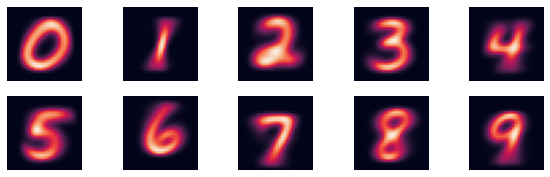

In [64]:
plt.figure(figsize=(10,3))
for i in range(10):
    avgImg = np.average(train.loc[train["labels"]==i].drop(["labels"], axis = 1),0)
    plt.subplot(2, 5, i+1)
    plt.imshow(avgImg.reshape((28,28))) 
    plt.axis('off')

### Train the data
    -Create the algorithm
    -Feed the algorithm with train data 

In [65]:
class GaussBayes():
    
    def fit(self, x, y, epsilon = 1e3):
        self.likelihoods ={}
        self.priors = {}
        self.k = set(y.astype(int))
        
        for k in self.k:
            x_k = x[y==k,:]
            N_k, D = x_k.shape
            mu_k = x_k.mean(axis = 0)
            
            self.likelihoods[k] = {"mean": x_k.mean(axis = 0), "cov": (1/(N_k-1)) * 
                                   np.matmul((x_k - mu_k).T, x_k - mu_k)+ epsilon * np.identity(D)} #Use identity to add a value to matrix (epsilon)
            self.priors[k] = len(x_k)/len(x)      
            
    def predict(self,x):
        N,D = x.shape
        P_hat = np.zeros((N, len(self.k)))
        
        for k, l in self.likelihoods.items():
            P_hat[:,k] = mvn.logpdf(x, l["mean"], l["cov"]) + np.log(self.priors[k])
        
        return P_hat.argmax(axis = 1)

### Transform dataframe to ndarray

In [66]:
x_train = x_train.to_numpy()
y_train = y_train.to_numpy()

x_test = x_test.to_numpy()
y_test = y_test.to_numpy()

### Gauss Bayes Model

In [67]:
magic_GB = GaussBayes()

In [68]:
magic_GB.fit(x_train,y_train)

In [69]:
train_pred = magic_GB.predict(x_train)

In [70]:
def accuracy(y, y_hat):
    return np.mean(y==y_hat)

In [71]:
#Training accuracy
accuracy(y_train,train_pred)

0.95805

In [72]:
#Test accuracy
test_pred = magic_GB.predict(x_test)

In [73]:
accuracy(y_test,test_pred)

0.9511

### Confusion matrix

In [74]:
actual = pd.Series(y_test.tolist(), name = "Actual")
prediction = pd.Series(test_pred.tolist(), name = "Predicted")
matrix = pd.crosstab(actual,prediction)

In [75]:
matrix

Predicted,0,1,2,3,4,5,6,7,8,9
Actual,,,,,,,,,,
0,968,0,1,1,0,0,3,1,6,0
1,0,1120,6,1,0,0,5,0,3,0
2,3,3,973,9,3,0,1,6,33,1
3,5,0,4,943,0,12,0,5,31,10
4,0,2,3,0,938,0,4,2,3,30
5,2,0,2,20,0,820,12,3,25,8
6,6,3,1,0,3,9,928,0,8,0
7,0,11,13,2,10,1,0,944,5,42
8,8,5,7,14,3,4,2,4,918,9


### Adding total count and success rate

In [76]:
matrix["Total"] = matrix.sum(axis = 1)
c = 0
error = []
for i in range(10):
    n = (((matrix[i][c] / matrix["Total"][c])))*100
    error.append(round(n,2))
    c += 1
matrix["Succ Rate%"] = error
matrix

Predicted,0,1,2,3,4,5,6,7,8,9,Total,Succ Rate%
Actual,,,,,,,,,,,,
0,968,0,1,1,0,0,3,1,6,0,980,98.78
1,0,1120,6,1,0,0,5,0,3,0,1135,98.68
2,3,3,973,9,3,0,1,6,33,1,1032,94.28
3,5,0,4,943,0,12,0,5,31,10,1010,93.37
4,0,2,3,0,938,0,4,2,3,30,982,95.52
5,2,0,2,20,0,820,12,3,25,8,892,91.93
6,6,3,1,0,3,9,928,0,8,0,958,96.87
7,0,11,13,2,10,1,0,944,5,42,1028,91.83
8,8,5,7,14,3,4,2,4,918,9,974,94.25


### Sorting success rate per label and plot

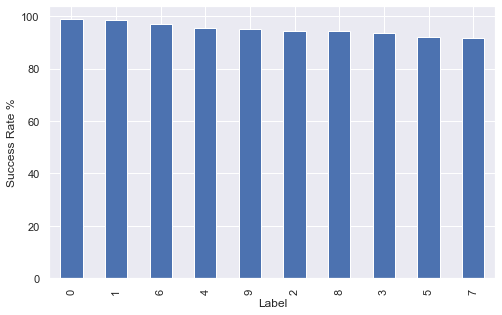

In [92]:
matrix["Succ Rate%"].sort_values(ascending = False).plot.bar(figsize = (8,5))
plt.ylabel("Success Rate %")
plt.xlabel("Label")
plt.show()

Even the accuracy is high, there are two labels in which the model has a hard time to figure them out (5 and 7)